In [1]:
%cd torchspdnet_untouched 

# %cd torchspdnet

import os, sys
sys.path.append(os.getcwd())

/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched


In [2]:
# Preliminaries 
import numpy as np
import pandas as pd
import time

from random import randint
import os
import shutil

from numpy import sqrt 
import torch as th
from scipy.stats import t
import sys

from datetime import datetime
from datetime import timedelta
import missingno as msno

# Enable anomaly detection
th.autograd.set_detect_anomaly(True)

import fastcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

import networkx as nx
from scipy.spatial.distance import squareform

from scipy.stats import rankdata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
random.seed(27)

import torch.nn as nn
from torch.utils import data

import torchspdnet.nn as spdnet
from torchspdnet.optimizers import MixOptimizer

from collections import Counter

In [30]:
df = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 0)
market_cap = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 1)

df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
market_cap['Dates'] = pd.to_datetime(market_cap['Dates'], infer_datetime_format=True)

df.index = df['Dates']
del df['Dates']
df = df.sort_index()

market_cap.index = market_cap['Dates']
del market_cap['Dates']
market_cap = market_cap.sort_index()

returns = df.pct_change(periods=1)
returns.tail()

,ABG SJ Equity,ADH SJ Equity,AEL SJ Equity,AFE SJ Equity,AFH SJ Equity,AFT SJ Equity,AGL SJ Equity,AIL SJ Equity,AIP SJ Equity,AMS SJ Equity,...,TGA SJ Equity,THA SJ Equity,TKG SJ Equity,TRU SJ Equity,TSG SJ Equity,TXT SJ Equity,VKE SJ Equity,VOD SJ Equity,WBO SJ Equity,WHL SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2023-12-07,-0.023719,0.000000,0.000000,-0.040570,-0.061489,-0.010539,0.001028,0.036961,-0.034783,0.026879,...,0.020618,0.000705,-0.052000,-0.025654,0.019185,0.000000,-0.014184,-0.015575,0.000077,-0.021780
2023-12-08,-0.063146,0.000000,-0.010000,-0.028571,0.029310,0.009941,-0.133194,-0.049505,-0.008108,-0.003209,...,0.016547,0.014085,-0.008439,0.015449,-0.005490,0.000000,-0.012950,0.010513,0.004461,0.013804
2023-12-11,-0.002443,0.004800,-0.055556,0.027353,0.005025,0.013359,-0.041542,-0.004167,0.023978,0.019262,...,-0.005290,0.006944,-0.025532,-0.018918,0.000000,0.009730,0.026239,0.003030,0.008347,0.001757
2023-12-12,-0.022229,0.000398,0.016043,-0.020613,0.000000,-0.014571,-0.075673,0.031381,0.039915,-0.017824,...,-0.035456,0.006897,0.029774,-0.023193,0.005521,-0.004283,0.003551,-0.005841,-0.006303,-0.020754
2023-12-13,0.003468,0.005173,0.000000,0.013739,0.000000,0.010562,0.007184,-0.002028,-0.011941,-0.009217,...,0.010886,-0.000685,0.001542,-0.000414,-0.019608,-0.005366,-0.004246,-0.005774,0.005120,0.004627


In [4]:
column_names = list(returns.columns)

# Printing column names to copy
print(column_names)

['ABG SJ Equity', 'ADH SJ Equity', 'AEL SJ Equity', 'AFE SJ Equity', 'AFH SJ Equity', 'AFT SJ Equity', 'AGL SJ Equity', 'AIL SJ Equity', 'AIP SJ Equity', 'AMS SJ Equity', 'ANG SJ Equity', 'ANH SJ Equity', 'APN SJ Equity', 'ARI SJ Equity', 'ARL SJ Equity', 'ATT SJ Equity', 'AVI SJ Equity', 'BAT SJ Equity', 'BAW SJ Equity', 'BHG SJ Equity', 'BID SJ Equity', 'BLU SJ Equity', 'BTI SJ Equity', 'BTN SJ Equity', 'BVT SJ Equity', 'BYI SJ Equity', 'CFR SJ Equity', 'CLS SJ Equity', 'CML SJ Equity', 'COH SJ Equity', 'CPI SJ Equity', 'CSB SJ Equity', 'DCP SJ Equity', 'DRD SJ Equity', 'DSY SJ Equity', 'DTC SJ Equity', 'EMI SJ Equity', 'EQU SJ Equity', 'EXX SJ Equity', 'FBR SJ Equity', 'FFA SJ Equity', 'FFB SJ Equity', 'FSR SJ Equity', 'FTB SJ Equity', 'GFI SJ Equity', 'GLN SJ Equity', 'GND SJ Equity', 'GRT SJ Equity', 'HAR SJ Equity', 'HCI SJ Equity', 'HDC SJ Equity', 'HMN SJ Equity', 'HYP SJ Equity', 'IMP SJ Equity', 'INL SJ Equity', 'INP SJ Equity', 'ITE SJ Equity', 'JSE SJ Equity', 'KAP SJ Equit

In [31]:
import pandas as pd
import numpy as np

# Assuming df and market_cap have been read and processed as per your initial snippet

dates_to_remove = [pd.to_datetime('2007-12-31'), pd.to_datetime('2013-01-01')]

# Remove the dates to remove from both dataframes
returns = returns[~returns.index.isin(dates_to_remove)]
market_cap = market_cap[~market_cap.index.isin(dates_to_remove)]

# Define the start and end of the test period
test_period_start = pd.to_datetime('2008-01-01')
test_period_end = pd.to_datetime('2012-12-31')

# Split data into test and train datasets based on the period, for both df and market_cap
test_df = returns.loc[test_period_start:test_period_end]
returns = pd.concat([returns.loc[:test_period_start - pd.Timedelta(days=1)], returns.loc[test_period_end + pd.Timedelta(days=1):]])

test_market_cap = market_cap.loc[test_period_start:test_period_end]
market_cap = pd.concat([market_cap.loc[:test_period_start - pd.Timedelta(days=1)], market_cap.loc[test_period_end + pd.Timedelta(days=1):]])

# Calculate the cutoff index to retain only the first 90% of the test dataset
cut_off_index_df = int(len(test_df) * 0.9)
cut_off_index_market_cap = int(len(test_market_cap) * 0.9)

# Apply the cutoff to both test datasets
test_returns = test_df.iloc[:cut_off_index_df]
test_market_cap = test_market_cap.iloc[:cut_off_index_market_cap]

# Now, you have train_df and test_df for your model's inputs, along with corresponding train_market_cap and test_market_cap for any additional analysis.


In [29]:
test_returns

,ABG SJ Equity,ADH SJ Equity,AEL SJ Equity,AFE SJ Equity,AFH SJ Equity,AFT SJ Equity,AGL SJ Equity,AIL SJ Equity,AIP SJ Equity,AMS SJ Equity,...,TGA SJ Equity,THA SJ Equity,TKG SJ Equity,TRU SJ Equity,TSG SJ Equity,TXT SJ Equity,VKE SJ Equity,VOD SJ Equity,WBO SJ Equity,WHL SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,


In [6]:
dim = 60
tri_a, tri_b = np.triu_indices(dim, k=1)

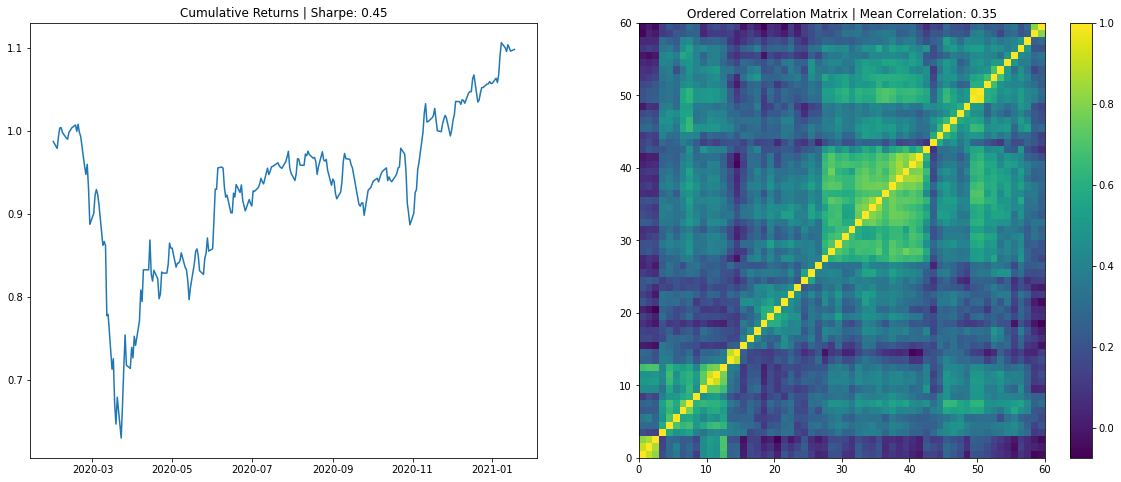

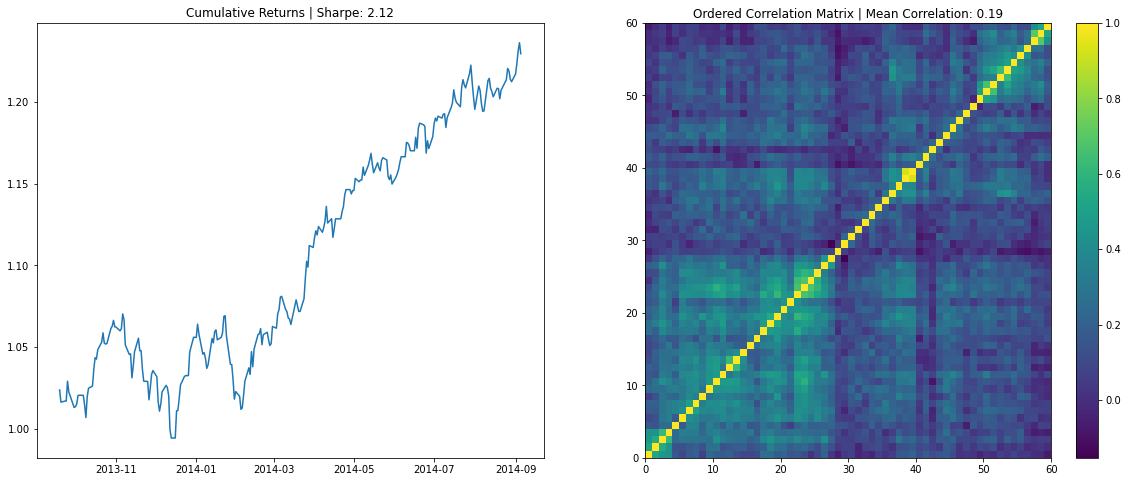

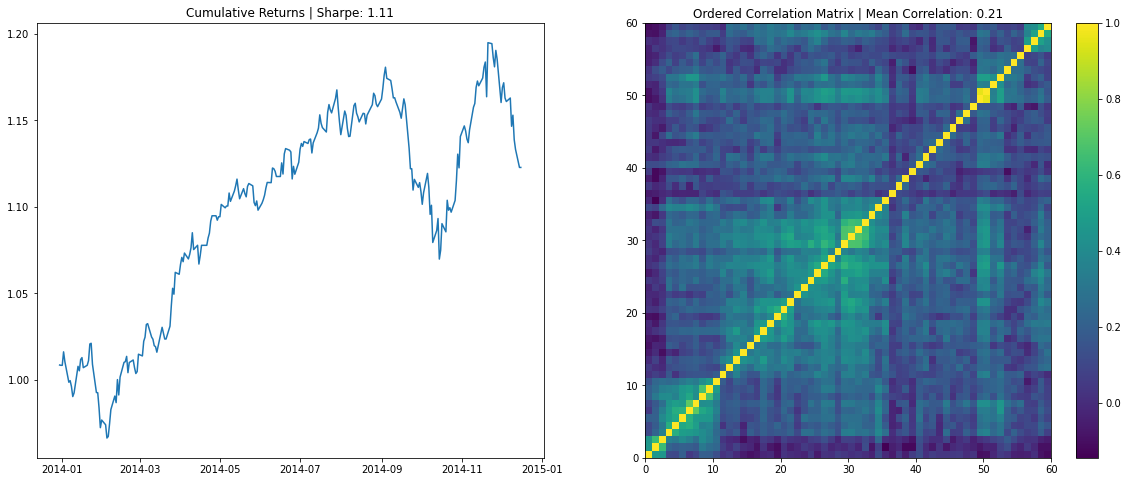

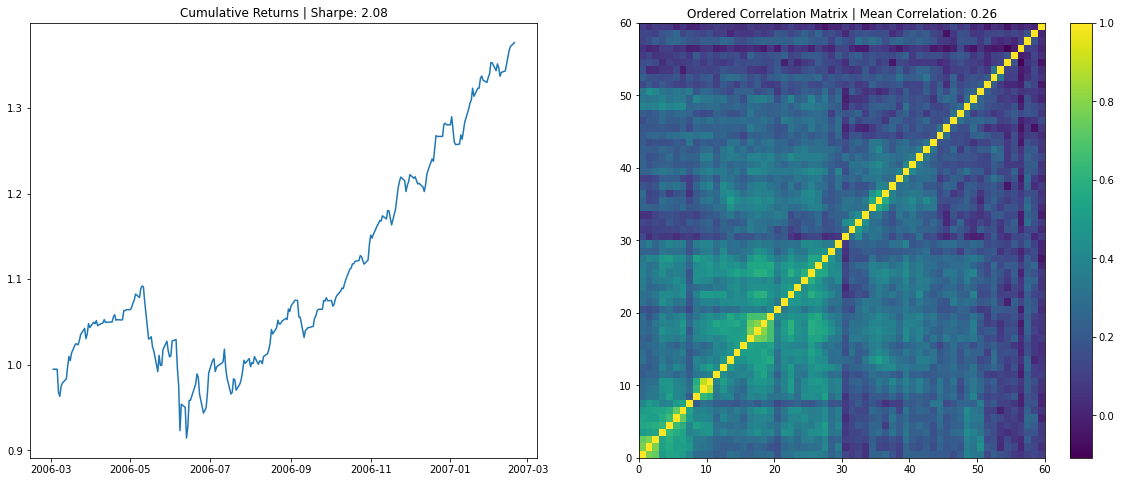

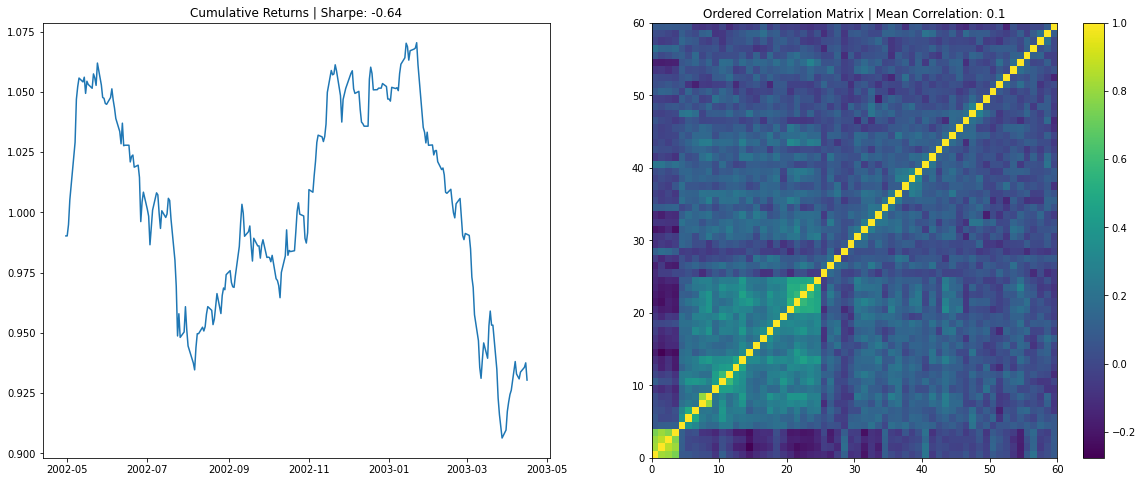

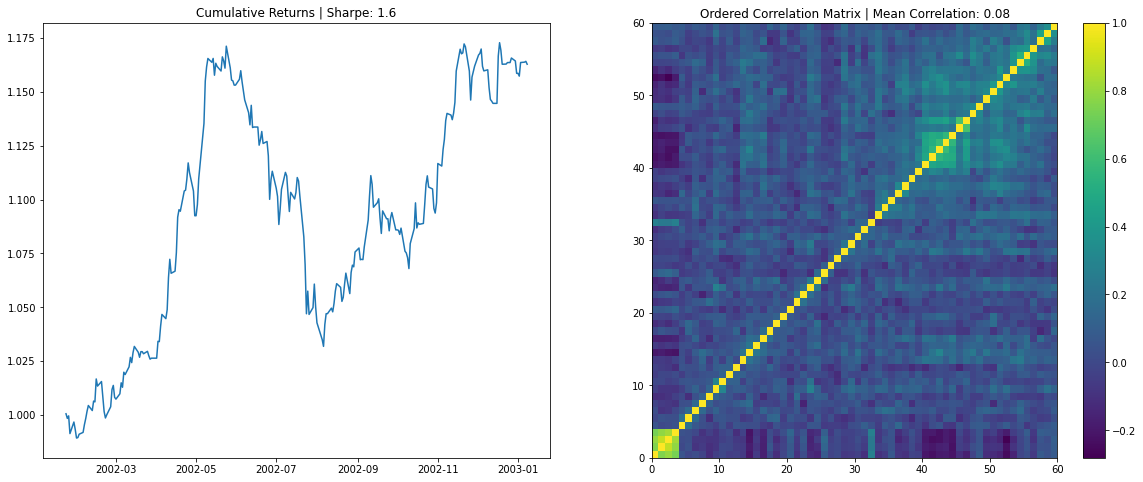

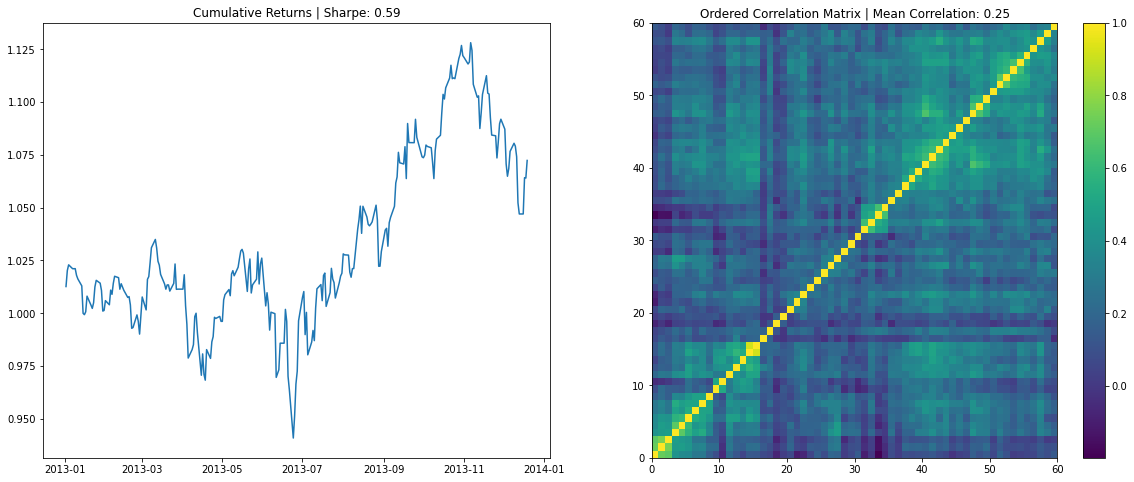

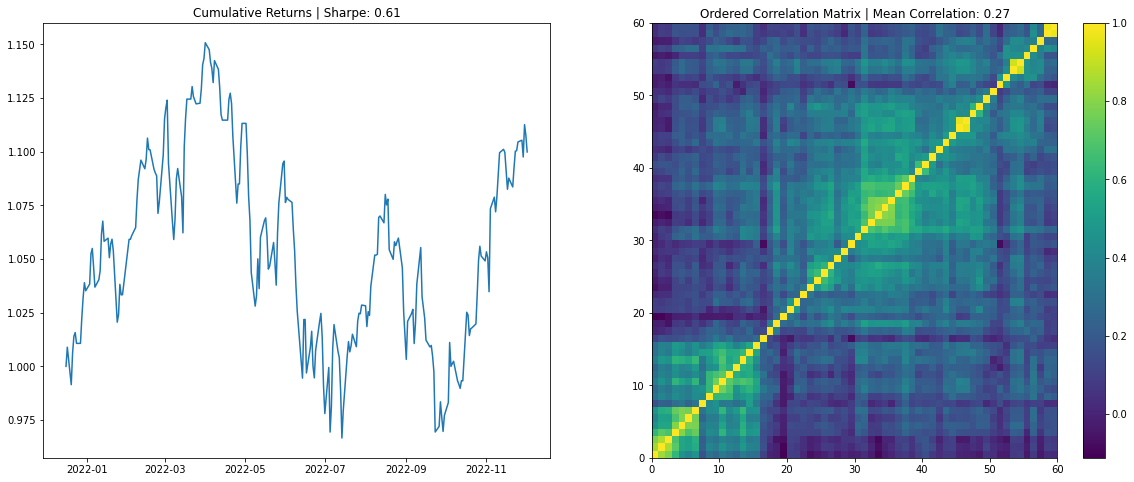

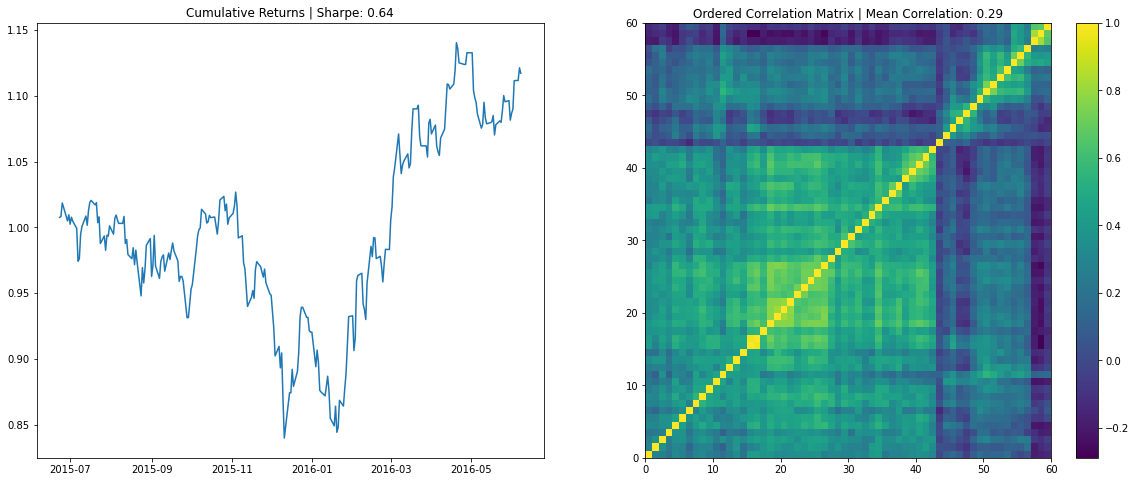

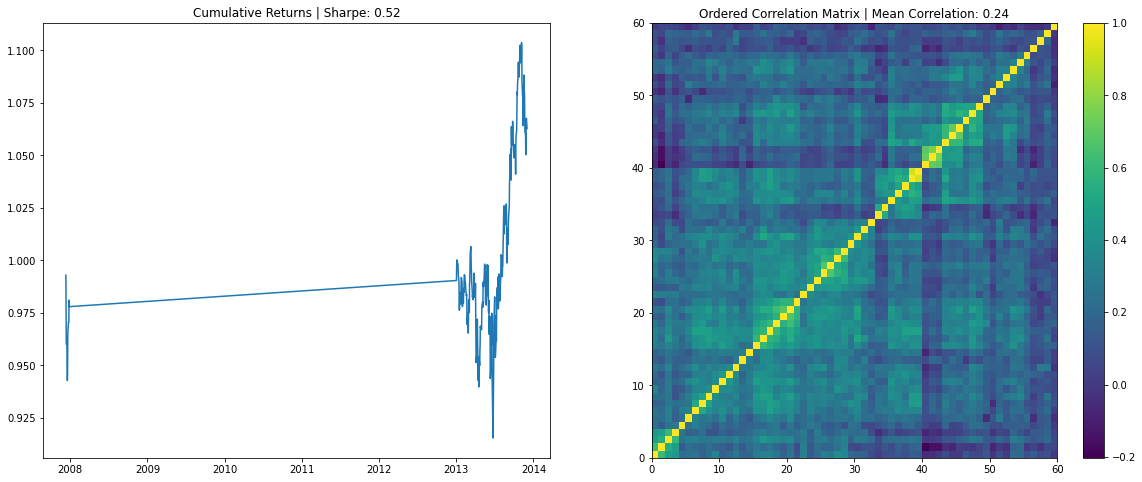

Stressed count: 6000, Rally count: 6000, Normal count: 6000


In [7]:
corr_vs_sharpe = []
stressed_mats = []
stressed_count = 0
rally_mats = []
rally_count = 0
normal_mats = []
normal_count = 0
plot_count = 0

# Create directories
for dir_name in ['stressed_mats_top60_dist', 'rally_mats_top60_dist', 'normal_mats_top60_dist']:
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)  
    os.makedirs(dir_name)  

while stressed_count < 6000 or rally_count < 6000 or normal_count < 6000:
    try:
        t_idx = randint(0, len(returns) - 252)
        #print(f"Selected start index for 252-day period: {t_idx}")

        period_returns = returns.iloc[t_idx:(t_idx + 252)]
        period_market_cap = market_cap.iloc[t_idx:(t_idx + 252)]

        # Remove columns where all values are NaN
        period_returns = period_returns.dropna(axis=1, how='all')
        #print(f"Remaining shape after removing all-NaN columns: {period_returns.shape}")
        
        # Remove constant columns
        non_constant_columns = period_returns.columns[period_returns.std() > 1e-8]
        if len(non_constant_columns) < 60:
            #print("Not enough non-constant columns. Skipping this iteration.")
            continue

        period_returns = period_returns[non_constant_columns]
        period_market_cap = period_market_cap[non_constant_columns]

        # Randomly select 60 stocks, assuming there are at least 60
        if len(period_returns.columns) >= 60:
            # Select top 60 stocks based on market capitalization
            avg_market_cap = period_market_cap.mean().sort_values(ascending=False)
            top_60_stocks = avg_market_cap.head(60).index
            period_returns = period_returns[top_60_stocks]
            
            #selected_columns = np.random.choice(period_returns.columns, 60, replace=False)
            #period_returns = period_returns[selected_columns]
        else:
            #print("Not enough columns to select 60 stocks. Skipping this iteration.")
            continue

        # Fill NaNs with 0
        period_returns = period_returns.fillna(0)

        idx = list(np.random.choice(len(period_returns.columns), dim, replace=False))

        # Calculate correlation
        corr = period_returns.corr().values
        #print(corr)
        if np.isnan(corr).any():
            #print("Correlation matrix contains NaNs. Skipping this iteration.")
            continue

        #print(f"Mean correlation: {np.nanmean(corr)}") 

        mean_return = period_returns[period_returns.columns[idx]].mean(axis=1).mean() * 252
        vol = period_returns[period_returns.columns[idx]].mean(axis=1).std() * np.sqrt(252)
        sharpe = mean_return / vol
        #print(f"Sharpe Ratio: {sharpe}")

        #dist = 1 - corr
        # Using the distance measure from Miori et al.
        # Application taken from Papenbrock et al. (2021)
        dist = np.sqrt(2 * (1 - corr))
        #print(dist)
        Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
        permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
        prows = corr[permutation, :]
        ordered_corr = prows[:, permutation]

        corr_vs_sharpe.append([corr.mean(), sharpe])

        # Define Sharpe ratio ranges for each category following Marti (2020)
        sharpe_low = -0.5  # Lower bound for "normal"
        sharpe_high = 2  # Upper bound for "normal"

        if sharpe < -0.5 and stressed_count < 6000:
            stressed_mats.append(ordered_corr)
            np.save(f'stressed_mats_top60_dist/mat_{stressed_count}.npy', ordered_corr)
            stressed_count += 1
            plot_flag = True
        elif sharpe > 2 and rally_count < 6000:
            rally_mats.append(ordered_corr)
            np.save(f'rally_mats_top60_dist/mat_{rally_count}.npy', ordered_corr)
            rally_count += 1
            plot_flag = True
        elif sharpe_low <= sharpe <= sharpe_high and normal_count < 6000:
            normal_mats.append(ordered_corr)
            np.save(f'normal_mats_top60_dist/mat_{normal_count}.npy', ordered_corr)
            normal_count += 1
            plot_flag = True
        else:
            plot_flag = False

        if plot_flag and plot_count < 10:
            # Plotting the cumulative returns and correlation matrix
            plt.figure(figsize=(20, 8))

            # Plotting cumulative returns
            plt.subplot(1, 2, 1)
            plt.plot((1 + period_returns.mean(axis=1)).cumprod())
            plt.title(f"Cumulative Returns | Sharpe: {np.round(sharpe, 2)}")

            # Plotting correlation matrix
            plt.subplot(1, 2, 2)
            plt.pcolormesh(ordered_corr)
            plt.colorbar()
            plt.title(f"Ordered Correlation Matrix | Mean Correlation: {np.round(np.nanmean(corr), 2)}")
            plt.show()

            plot_count += 1 

    except Exception as e:
        print(f"Error: {e}")

# Print the counts
print(f"Stressed count: {stressed_count}, Rally count: {rally_count}, Normal count: {normal_count}")

In [8]:
stressed_mats

[array([[ 1.00000000e+00,  8.22154142e-01,  8.04301017e-01, ...,
         -1.06888988e-02,  2.68874979e-02,  7.85852696e-02],
        [ 8.22154142e-01,  1.00000000e+00,  8.70237113e-01, ...,
         -5.32485422e-02,  1.74822672e-02,  8.10669586e-02],
        [ 8.04301017e-01,  8.70237113e-01,  1.00000000e+00, ...,
         -4.00320109e-02, -9.66496926e-03,  8.54729727e-02],
        ...,
        [-1.06888988e-02, -5.32485422e-02, -4.00320109e-02, ...,
          1.00000000e+00,  1.95088917e-01,  6.19805287e-04],
        [ 2.68874979e-02,  1.74822672e-02, -9.66496926e-03, ...,
          1.95088917e-01,  1.00000000e+00,  9.68224913e-02],
        [ 7.85852696e-02,  8.10669586e-02,  8.54729727e-02, ...,
          6.19805287e-04,  9.68224913e-02,  1.00000000e+00]]),
 array([[ 1.        ,  0.2955393 ,  0.16788147, ...,  0.02244201,
          0.00498681, -0.00310463],
        [ 0.2955393 ,  1.        ,  0.41426919, ...,  0.18728846,
          0.16559998,  0.12518139],
        [ 0.16788147,  0.

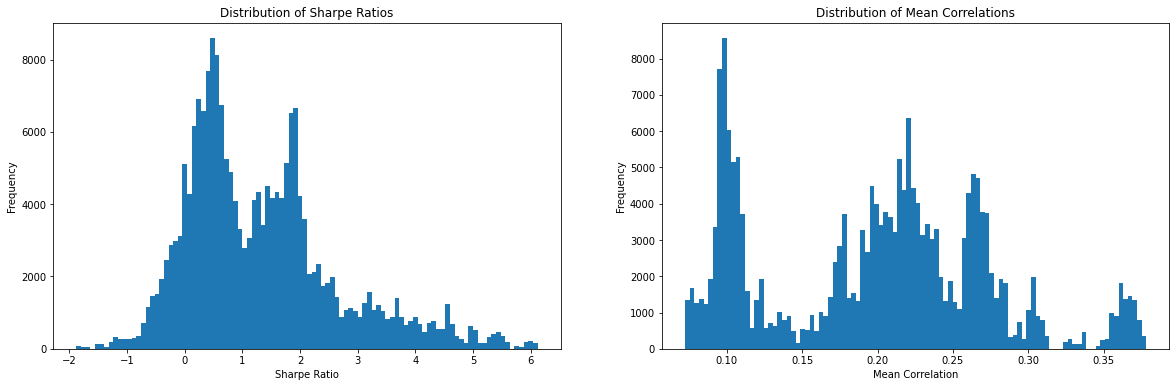

In [9]:
def plot_distributions(corr_vs_sharpe, stressed_mats, rally_mats, normal_mats):
    # Extract and calculate the mean of mean correlations
    mean_correlations = [np.mean(item[0]) for item in corr_vs_sharpe if len(item) > 1]
    sharpe_ratios = [item[1] for item in corr_vs_sharpe if len(item) > 1]

    # Plot distribution of Sharpe Ratios
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.hist(sharpe_ratios, bins=100)
    plt.title('Distribution of Sharpe Ratios')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')

    # Plot distribution of Mean Correlations
    plt.subplot(1, 2, 2)
    plt.hist(mean_correlations, bins=100)
    plt.title('Distribution of Mean Correlations')
    plt.xlabel('Mean Correlation')
    plt.ylabel('Frequency')
    plt.show()

# Usage
plot_distributions(corr_vs_sharpe, stressed_mats, rally_mats, normal_mats)

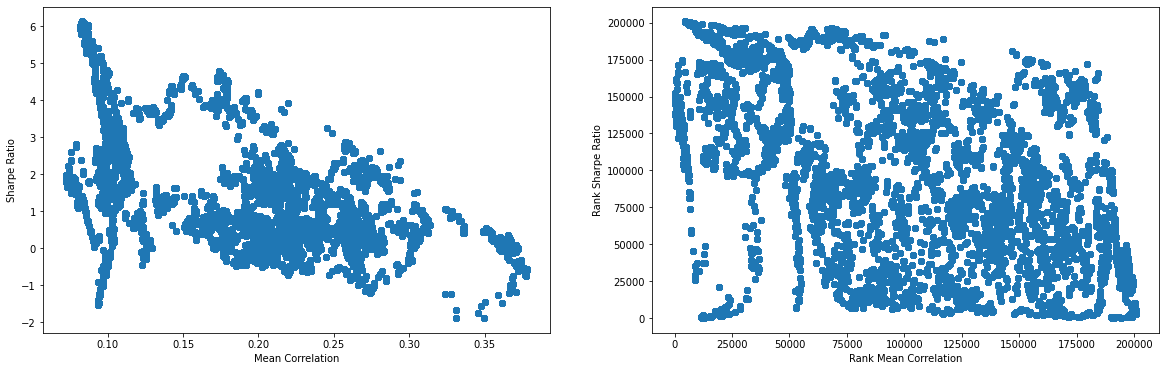

In [10]:
# Convert corr_vs_sharpe to a NumPy array if it's not already
corr_vs_sharpe_array = np.array(corr_vs_sharpe)

plt.figure(figsize=(20, 6))

# First plot: Scatter plot of mean correlation vs. sharpe
plt.subplot(1, 2, 1)
plt.scatter(corr_vs_sharpe_array[:, 0], corr_vs_sharpe_array[:, 1])
plt.xlabel('Mean Correlation')
plt.ylabel('Sharpe Ratio')

# Second plot: Scatter plot of rank of mean correlation vs. rank of sharpe
plt.subplot(1, 2, 2)
plt.scatter(rankdata(corr_vs_sharpe_array[:, 0]), rankdata(corr_vs_sharpe_array[:, 1]))
plt.xlabel('Rank Mean Correlation')
plt.ylabel('Rank Sharpe Ratio')

plt.show()


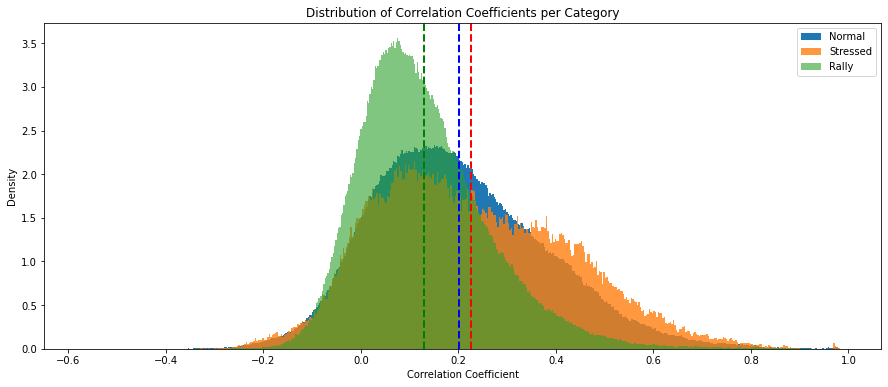

In [11]:
def plot_correlation_coefficient_distributions(stressed_mats, rally_mats, normal_mats, tri_a, tri_b):
    # Extract correlation coefficients for each category
    stressed_corr_coeffs = [mat[tri_a, tri_b] for mat in stressed_mats]  
    rally_corr_coeffs = [mat[tri_a, tri_b] for mat in rally_mats]        
    normal_corr_coeffs = [mat[tri_a, tri_b] for mat in normal_mats]      

    # Flatten the lists
    stressed_corr_coeffs = [item for sublist in stressed_corr_coeffs for item in sublist]
    rally_corr_coeffs = [item for sublist in rally_corr_coeffs for item in sublist]
    normal_corr_coeffs = [item for sublist in normal_corr_coeffs for item in sublist]

    # Number of bins
    nbins = 500

    # Plotting distribution of correlation coefficients per category
    plt.figure(figsize=(15, 6))

    plt.hist(normal_corr_coeffs, bins=nbins, alpha=1, label='Normal', density=True, log=False)
    plt.axvline(x=np.mean(normal_corr_coeffs), color='b', linestyle='dashed', linewidth=2)

    plt.hist(stressed_corr_coeffs, bins=nbins, alpha=0.8, label='Stressed', density=True, log=False)
    plt.axvline(x=np.mean(stressed_corr_coeffs), color='r', linestyle='dashed', linewidth=2)

    plt.hist(rally_corr_coeffs, bins=nbins, alpha=0.6, label='Rally', density=True, log=False)
    plt.axvline(x=np.mean(rally_corr_coeffs), color='g', linestyle='dashed', linewidth=2)

    plt.legend()
    plt.title('Distribution of Correlation Coefficients per Category')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Density')
    
    plt.show()

# Usage example (make sure tri_a and tri_b are correctly defined)
dim = 60
tri_a, tri_b = np.triu_indices(dim, k=1)
plot_correlation_coefficient_distributions(stressed_mats, rally_mats, normal_mats, tri_a, tri_b)

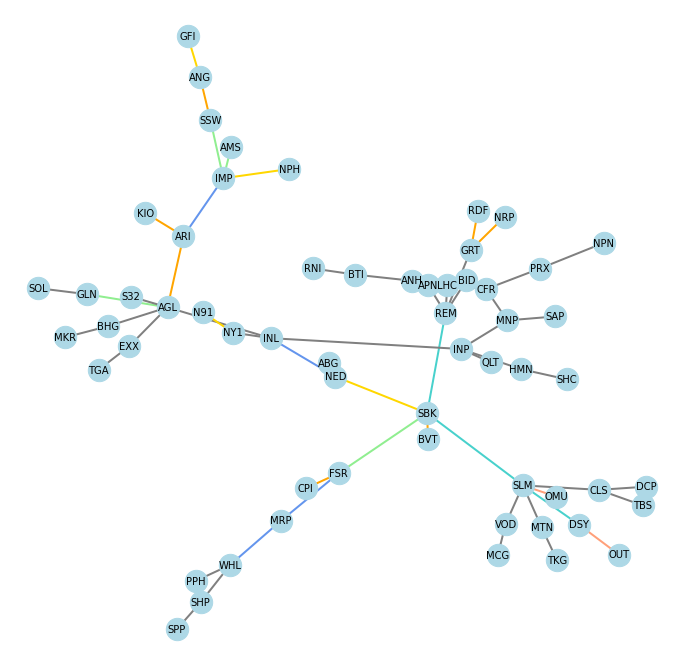

In [12]:
def plot_minimum_spanning_tree(returns, market_cap, num_stocks=60, trading_days=1260):

    # Select stocks and trading days
    recent_returns = returns.tail(trading_days)
    avg_market_cap = market_cap.mean().sort_values(ascending=False)
    top_60_stocks = avg_market_cap.head(num_stocks).index
    recent_returns = recent_returns[top_60_stocks].fillna(0)

    # Compute the correlation matrix and convert it to a distance matrix
    correlation_matrix = recent_returns.corr()
    distance_matrix = np.sqrt(2 * (1 - correlation_matrix))
    # distance_matrix = 1-correlation_matrix

    # Create a graph from the distance matrix
    G = nx.Graph()
    for i in range(len(distance_matrix)):
        for j in range(i + 1, len(distance_matrix)):
            G.add_edge(top_60_stocks[i], top_60_stocks[j], weight=distance_matrix.iloc[i, j])

    # Compute the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)
    'yellowgreen', 'deepskyblue', 'c', 'm', 'y', 'k', 'mediumturquoise', 'lightsalmon', 'cornflowerblue', 'gold'
    # Categorize edges based on connection strength
    edge_colors = []
    for u, v, data in mst.edges(data=True):
        d = data['weight']
        if 0.5 < d <= 0.6:
            color = 'gold'
        elif 0.60 < d <= 0.75:
            color = 'lightgreen'
        elif 0.75 < d <= 0.80:
            color = 'mediumturquoise'
        elif 0.80 < d <= 0.85:
            color = 'lightsalmon'
        elif 0.85 < d <= 0.90:
            color = 'orange'
        elif 0.90 < d <= 0.95:
            color = 'cornflowerblue'
        else:
            color = 'gray' # Default color for other values
        edge_colors.append(color)
    
    # Remove 'SJ Equity' from the labels
    labels = {node: node.replace(' SJ Equity', '') for node in mst.nodes()}

    # Plot the minimum spanning tree with categorized edge colors
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(mst, seed=42)  # for consistent layout
    nx.draw_networkx_nodes(mst, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_labels(mst, pos, labels=labels, font_size=10)
    nx.draw_networkx_edges(mst, pos, edge_color=edge_colors, width=2)
#     plt.title(f"Minimum Spanning Tree of Price Returns (Day {start_day} to {start_day+trading_days})")
    plt.savefig('mst.png', bbox_inches='tight')
    plt.axis('off')

# Plotting
plot_minimum_spanning_tree(returns, market_cap)


In [13]:
import pandas as pd
import numpy as np

# Assuming corr_vs_sharpe is a list where each element is [matrix, sharpe_ratio]
# Flatten each matrix into a 1D array and extract Sharpe ratios
flattened_matrices = [matrix.flatten() for matrix, _ in corr_vs_sharpe]
sharpe_ratios = [sharpe_ratio for _, sharpe_ratio in corr_vs_sharpe]

# Create a DataFrame for flattened matrices
df_matrices = pd.DataFrame(flattened_matrices)

# Add the Sharpe ratios as a new column to the DataFrame
df_matrices['Sharpe_Ratio'] = sharpe_ratios

# Save the DataFrame to a CSV file
csv_file_path = '/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched/matrix_sharpe_data.csv'  # Adjust the path as needed
df_matrices.to_csv(csv_file_path, index=False)

csv_file_path  # Output the path to use in the next step


'/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched/matrix_sharpe_data.csv'

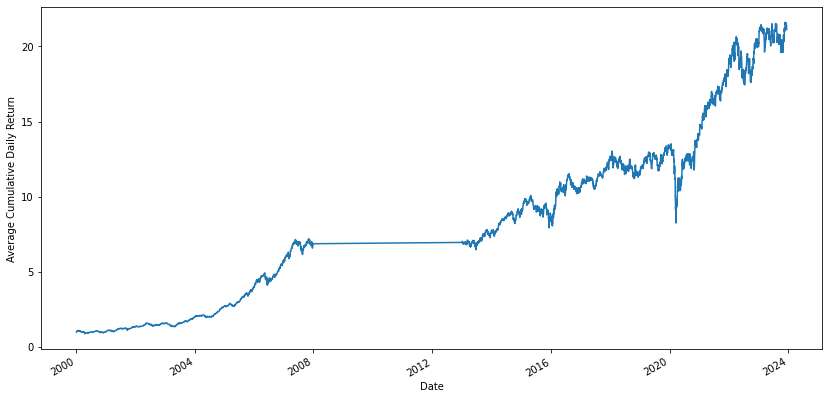

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'returns' and 'market_cap' are pandas DataFrames
# and the index for 'returns' is the datetime of the returns
# Ensure that the 'market_cap' DataFrame is aligned with 'returns' and has the same column names and index.

# Initialize an empty list to store average returns
average_daily_returns = []

# Loop through each day in the returns DataFrame
for date in returns.index:
    # Select the market cap for the current day
    current_market_cap = market_cap.loc[date]
    
    # Find the top 60 stocks by market cap for the current day
    top_60_stocks = current_market_cap.nlargest(60).index
    
    # Select the returns for the top 60 stocks
    current_returns = returns.loc[date, top_60_stocks]
    
    # Calculate the average return for the current day for the top 60 stocks
    average_return = current_returns.mean()
    
    # Store the average return
    average_daily_returns.append(average_return)

# Convert the average daily returns list into a pandas Series
average_daily_returns_series = pd.Series(average_daily_returns, index=returns.index)

# cumrets
cumulative_returns = (1 + average_daily_returns_series).cumprod()

# Plot the time series of average daily returns
plt.figure(figsize=(14, 7))
cumulative_returns.plot()
plt.xlabel('Date')
plt.ylabel('Average Cumulative Daily Return')
plt.savefig('cumretstop60.png', bbox_inches='tight')
plt.show()



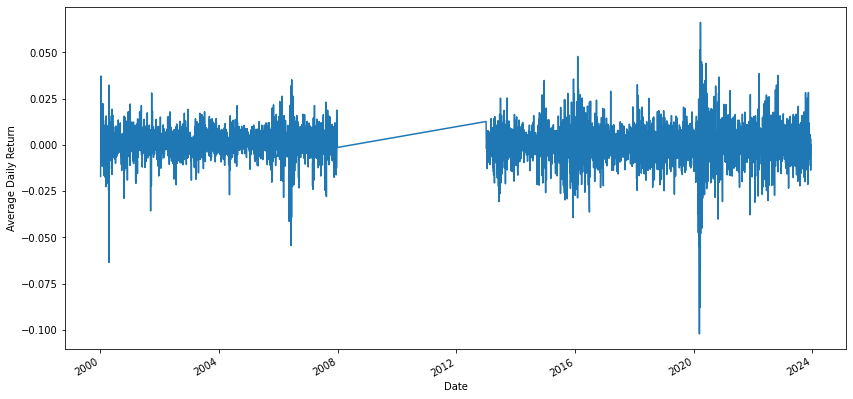

In [15]:
# Convert the average daily returns list into a pandas Series
average_daily_returns_series = pd.Series(average_daily_returns, index=returns.index)

# Plot the time series of average daily returns
plt.figure(figsize=(14, 7))
average_daily_returns_series.plot()
plt.xlabel('Date')
plt.ylabel('Average Daily Return')
plt.savefig('retstop60.png', bbox_inches='tight')
plt.show()

In [32]:
corr_vs_sharpe_df = pd.DataFrame(columns=['Correlation', 'Sharpe', 'Label'])

# Create directories
for dir_name in ['stressed_mats_top60_dist_test', 'rally_mats_top60_dist_test', 'normal_mats_top60_dist_test']:
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)  
    os.makedirs(dir_name)  

for t_idx in range(0, len(test_returns) - 252):
    start_date = returns.index[t_idx+252] 
    period_returns = test_returns.iloc[t_idx:(t_idx + 252)].fillna(0)
    period_market_cap = test_market_cap.iloc[t_idx:(t_idx + 252)].fillna(0)

    # Randomly select 60 stocks, assuming there are at least 60
    if len(period_returns.columns) >= 60:
        # Select top 60 stocks based on market capitalization
        avg_market_cap = period_market_cap.mean().sort_values(ascending=False)
        top_60_stocks = avg_market_cap.head(60).index
        period_returns = period_returns[top_60_stocks]
    else:
        #print("Not enough columns to select 60 stocks. Skipping this iteration.")
        continue

    # Fill NaNs with 0
    period_returns = period_returns.fillna(0)

    # Calculate correlation
    corr = period_returns.corr().fillna(0).values
    
    # Sharpe values
    mean_return = period_returns.mean(axis=1).mean() * 252
    vol = period_returns.mean(axis=1).std() * np.sqrt(252)
    sharpe = mean_return / vol
    
    print(sharpe)
    
    # Order corr
    dist = np.sqrt(2 * (1 - corr))
    #print(dist)
    Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
    permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
    prows = corr[permutation, :]
    ordered_corr = prows[:, permutation]
    
    corr_vs_sharpe.append([corr.mean(), sharpe])
    
    # Define Sharpe ratio ranges for each category following Marti (2020)
    sharpe_low = -0.5  # Lower bound for "normal"
    sharpe_high = 2  # Upper bound for "normal"
    


-0.6513113515932493
-0.6523226506641328
-0.7345195869298898
-0.6993863560011485
-0.674442802187088
-0.6593965997413975
-0.6992081177296399
-0.6450688225684541
-0.558726608836827
-0.47720703442458223
-0.47873659564022336
-0.4276151199086853
-0.3182980396464563
-0.25819840109011094
-0.13531780166777846
0.04842072454491267
-0.04159481741609293
-0.002718085710928979
-0.12845982382579998
-0.155633480978335
-0.14273910341412865
-0.25361423865092014
-0.25234148059549927
-0.31155980262228566
-0.42145302724376926
-0.48187608528453324
-0.39872517666535817
-0.4686283319196537
-0.3815547342935274
-0.3001197790369033
-0.19401477216894292
-0.32581198272453
-0.32908885011250744
-0.4936403142366301
-0.43579178875457736
-0.44719612873380826
-0.5308774458260632
-0.40253578282558056
-0.42644561968598793
-0.4078056629060576
-0.44240294225005916
-0.5453696091572663
-0.5720693690877457
-0.6359962569441727
-0.7197822713659171
-0.6681517925591696
-0.6464087212268895
-0.7226314634586064
-0.7295725937562616
-0.

1.381304423857702
1.2922445015772865
1.384418017885962
1.4017550337140665
1.4557444110552624
1.5432327536075605
1.604833275208381
1.6139034858222823
1.6494109514376563
1.584073087231919
1.6344840826753286
1.831098555965377
1.7640439310063787
1.6828032819120122
1.6451414166749085
1.6485520505431819
1.6607515841138412
1.6265131124855812
1.6849594058987247
1.5760571857982195
1.5482653770712804
1.6622593949472604
1.61294603951284
1.5843196659207794
1.5498730414459627
1.5354816339080624
1.5322149910029326
1.6115946738628144
1.6820797733955055
1.7086132855172473
1.6603445388382372
1.6668325415107157
1.8105099956324806
2.0038129582761064
1.8945194145081095
1.9455493571981988
1.9365092314715782
1.814912484342683
1.8078208049732907
1.7829077751309168
1.8187613711673623
1.8486547325016651
1.848116002132726
1.8914956517492518
1.8933791969538047
1.9521051019569247
2.0497246191386327
1.95213463859104
1.930813650215482
1.956103170332458
2.0902707891961065
2.111355802896776
2.0996983794239705
2.03418

1.0417992422237974
1.0803249158223478
0.9613403507786117
0.8745023537658567
0.9220566689566114
0.8388483462299685
0.7911374122765334
0.8403940303508945
0.9708375798833409
0.8746354844498399
0.873125190219976
0.9106955361655278
0.9074187143896894
1.0106139866412895
0.9284945537325183
0.9832012775399045
1.0131078782826226
0.9975824995944053
1.0418182427648552
1.1339165673529847
1.1458417025978185
1.1346999194668383
1.2180752012812242
1.232313296830003
1.3006334265845776
1.168091135041688
1.1382201201870608
1.173142472042555
1.2016278837147387
1.201622196321083
1.122261138001658
1.0482110326574556
0.9962308962809263
1.0469383040831142
1.0757764001486234
0.960096536308486
